In [1]:
import cPickle as pickle
from download_songs import BinacaYear, Song
import glob
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
from litcm import LIT
import sys
default_stdout = sys.stdout
default_stderr = sys.stderr
reload(sys)
sys.stdout = default_stdout
sys.stderr = default_stderr
sys.setdefaultencoding('utf-8')
lit = LIT(labels=['hin', 'eng'], transliteration=True)

In [2]:
def analyse(by):
    word_list = collections.defaultdict(float)
    
    for song in by.songs:
        tokens = word_tokenize(song.lyrics)
        for word in tokens:
            word_list[word] += 1
    
    total_words = sum(word_list.values())
    word_list = {k: v/total_words for k, v in word_list.iteritems()}
    return word_list


In [2]:
binaca_year = {}
for i in glob.glob("./songs/*.p"):
    binaca_year[int(i[-6:-2])] = pickle.load(open(i, "rb"))
    
    
excel = ""
for by in binaca_year.values():
    for song in by.songs:
        excel += song.lyrics
        excel += '\n'

f = open('binaca_songs.csv', 'wb+')
f.write(excel)
f.close()

In [4]:
binaca_dict = {}
for year in binaca_year.keys():
    binaca_dict[year] = analyse(binaca_year[year])


In [33]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
for i in open('hindi_stopwords.txt', 'r').read().split('\n'):
    stopWords.add(i[:-1])
    
vocab = set()
for keys in binaca_dict.values():
    for i in keys.keys():
        vocab.add(i)

final_list = set()
for i in vocab:
    local_word = i
    try:
        local_word = lit.identify(i).split('=')[1][:-1]
        flag = False
        for j in stopWords:
            if local_word == j:
                flag = True
        if not flag:
            final_list.add(i)
    except:
        if not i in stopWords:
            final_list.add(i)

In [35]:
def combine_dict(year_range):
    d = collections.defaultdict(float)
    for year in year_range:
        for k, v in binaca_dict[year].iteritems():
            if k in final_list:
                d[k] += v
    return d

def get_top_n_words(n, year_range):
    d = combine_dict(year_range)
    m = [[v, k] for k, v in d.iteritems()]
    m.sort(reverse=True)
    return set(map(lambda i: i[1], m[n]))

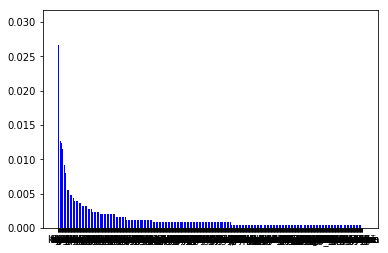

In [7]:
d = binaca_dict[1954]
m = [(v, k) for k, v in d.iteritems()]
m.sort(reverse=True)
x = range(len(m))
plt.bar(x, map(lambda i: i[0], m), 1/1.5, color="blue")
plt.xticks(x, map(lambda i: i[1], m))
plt.show()

In [37]:
#see how words changed over time

s_v = slice(0, 100)
seta = get_top_n_words(s_v, range(1955, 1965))
setb = get_top_n_words(s_v, range(1973, 1983))

for i in seta:
    if i not in setb:
        print i, ',',
print
print '-' * 81

for i in setb:
    if i not in seta:
        print i, ',',
print

badal , jaago , haay , nain , haiyya , kaun , jiya , & , wah , kahe , dur , mohabbat , gam , piya , apna , zara , dana , rahe , karu , ai , hame , kare , maama , hun , aankho , tumhe , thi ,
---------------------------------------------------------------------------------
baat , hay , jayenge , aayi , bas , chhod , naam , ru , sun , yaad , om , hoga , yaar , cha , hari , jana , ik , chali , nam , sath , pal , kam , jaan , aisa , aise , bina , sa ,


In [42]:
#see how words changed over time

s_v = slice(0, 300)
seta = get_top_n_words(s_v, range(1954, 1963))
setb = get_top_n_words(s_v, range(1964, 1973))
setc = get_top_n_words(s_v, range(1974, 1983))

for i in seta:
    if i not in setb and i not in setc:
        print i, ',',
print
print '-' * 81

for i in setb:
    if i not in seta and i not in setc:
        print i, ',',
print
print '-' * 81

for i in setc:
    if i not in seta and i not in setb:
        print i, ',',

jaadu , hindustani , bhee , aasman , bhala , pyare , jaag , bichhua , utha , khwaab , jan , upar , dhire , pasina , leke , jiwan , jaago , aadhee , 2 , aana , pyara , bago , chaand , garibon , gagan , dekhe , kyun , bah , kya-kya , pade , haar , dole , nain , gul , jamuna , ichak , prit , pahla , ( , kahee , nache , raahi , tufan , saiya , haiyya , khoya , panchhi , roye , bam , & , sahi , haa , mann , zamana , wala , singapur , diye , saval , nashe , bhayo , nadiya , wah , abdul , barkhaa , bura , mora , pukare , jamin , manzil , tufaan , gayo , bhigi , chaman , aaun , dana , chhoti , najar , dadi-amma , ras , maama , ) , - , bade , tir , sikh , tim , mast , naye , inasan , aanchal , nai , jaae , safar , chamka , paar , meree , peeke , kho , desh ,
---------------------------------------------------------------------------------
chain , sathi , ganga , yippi , hotho , jindagi , li , saayonara , jaayege , raste , muhabbat , fat , mehabub , maan , chaal , der , lala , sham , samajh , gi

In [9]:
import sys
sys.path.insert(0, "/home/harshil/Apps/faiss/")
import faiss

Failed to load GPU Faiss: No module named swigfaiss_gpu
Faiss falling back to CPU-only.


In [10]:
year_data = np.zeros([len(binaca_dict.keys()), len(vocab)]).astype('float32')

word_key = dict()
for i, val in enumerate(vocab):
    word_key[val] = i

for year in binaca_year.keys():
    for k, v in binaca_dict[year].iteritems():
        year_data[year-min(binaca_dict.keys())][word_key[k]] = float(v)

year_data = np.ascontiguousarray(year_data.T)

In [11]:
k = 10
index = faiss.IndexFlatL2(year_data.shape[1])
index.add(year_data)
D, I = index.search(year_data, k+1)
pickle.dump(I, open('indexes.p', 'wb+'))

In [7]:
I = pickle.load(open('indexes.p', 'rb+'))

In [8]:
import networkx as nx
G=nx.Graph()
G.add_nodes_from(range(len(vocab)))

for i in range(len(vocab)):
    for j in I[i]:
        if j == i:
            continue
        G.add_edge(i, j)

In [9]:
def print_i(j):
    print vocab[j]
    for i in G.neighbors(j):
        print vocab[i],

print_i(1732)

hindustani
desh dir rona radhika bhigi abhi dadi-amma madhuban saval nasha


In [10]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics

In [11]:
vocab.index('hindustani')

1732

In [12]:
adj_mat = nx.to_numpy_matrix(G)
sc = SpectralClustering(100, affinity='precomputed', eigen_solver='arpack')
sc.fit(adj_mat)

print('spectral clustering')
print(sc.labels_)

/home/harshil.goel/.local/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


spectral clustering
[32 26  2 ..., 79  2 78]


In [13]:
pickle.dump(sc, open('sc.p', 'wb+'))

In [25]:
for i, val in enumerate(sc):
    if val == 99:
        print vocab[i]

gayee
want
shivam
ghadi
shala
jani
jaise-taise
say
zor
kamare
taram
dana-dan
upar-niche
aai
play
jhula
tam
yammaa
ui
jisaki
jiyraa
dushmano
we
janaab-e-aali
nafarat
duje
mitva
marzi
tara-ram-pam-pam-pam-pam
chameli
mazedar
samaa
humsa
satyam
gahraa
sundram
shan
jamke
naati
shamasha
nikhar
shaan
lambi
aapka
pakde
chana
bane
paw
dont
lui
tamasha
aahan
naseeb
kisme
sipahi
gulashan
khilaunga
each
yak-b-yak
angane
garam
qisamat
shamil
aha
khilega
rakhta
other
chhu
jodta
come
khudgarzi
bhai
bara
rambha
mewa
jnardan
joh
jon
know
khubasurat
